In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [2]:
# 예측: 앙상블 + 딥러닝 ROC/AUC
# ===========================================================

# 1. 라이브러리 설치 및 임포트


# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score


In [3]:

# 2.  건강 검진 데이터 생성
print("\n  건강 검진 데이터 생성")
print("-" * 50)

np.random.seed(42)
n_patients = 5000

print(f" {n_patients:,}명의 건강 검진 데이터 생성 중...")

# 기본 인구통계학적 정보
age = np.random.normal(45, 15, n_patients).clip(20, 85)
gender = np.random.choice([0, 1], n_patients, p=[0.52, 0.48])  # 0=여성, 1=남성

# 신체 계측
height = np.where(gender == 1,
                 np.random.normal(173, 7, n_patients),
                 np.random.normal(160, 6, n_patients)).clip(140, 200)
weight = np.where(gender == 1,
                 np.random.normal(75, 12, n_patients),
                 np.random.normal(58, 10, n_patients)).clip(40, 120)
bmi = weight / (height/100)**2

# 혈압 (mmHg)
systolic_bp = np.random.normal(125, 18, n_patients).clip(90, 200)
diastolic_bp = np.random.normal(80, 12, n_patients).clip(50, 120)
diastolic_bp = np.minimum(diastolic_bp, systolic_bp - 15)  # 현실적인 관계

# 혈액 검사
fasting_glucose = np.random.normal(95, 20, n_patients).clip(70, 300)
total_cholesterol = np.random.normal(200, 35, n_patients).clip(120, 400)
hdl_cholesterol = np.where(gender == 1,
                          np.random.normal(45, 10, n_patients),
                          np.random.normal(55, 12, n_patients)).clip(20, 100)
ldl_cholesterol = np.random.normal(120, 30, n_patients).clip(50, 300)
triglycerides = np.random.lognormal(4.7, 0.5, n_patients).clip(50, 500)

# 간 기능 검사
alt = np.random.gamma(2, 15, n_patients).clip(5, 200)
ast = np.random.gamma(2, 12, n_patients).clip(5, 150)

# 신장 기능 검사
creatinine = np.where(gender == 1,
                     np.random.normal(1.0, 0.2, n_patients),
                     np.random.normal(0.8, 0.15, n_patients)).clip(0.5, 3.0)
bun = np.random.normal(15, 4, n_patients).clip(5, 50)

# 혈액학적 검사
hemoglobin = np.where(gender == 1,
                     np.random.normal(15, 1.5, n_patients),
                     np.random.normal(13, 1.2, n_patients)).clip(8, 20)
hematocrit = hemoglobin * 3  # 대략적인 관계
wbc_count = np.random.normal(6500, 1500, n_patients).clip(3000, 15000)
platelet_count = np.random.normal(250000, 50000, n_patients).clip(100000, 500000)

# 심전도 및 기타 검사
ecg_abnormal = np.random.binomial(1, 0.15, n_patients)
chest_xray_abnormal = np.random.binomial(1, 0.08, n_patients)

# 생활습관
smoking_status = np.random.choice([0, 1, 2], n_patients, p=[0.6, 0.25, 0.15])  # 0=비흡연, 1=과거흡연, 2=현재흡연
alcohol_consumption = np.random.choice([0, 1, 2, 3], n_patients, p=[0.3, 0.4, 0.25, 0.05])  # 0=없음, 1=가끔, 2=보통, 3=많음
exercise_frequency = np.random.choice([0, 1, 2, 3], n_patients, p=[0.3, 0.3, 0.3, 0.1])  # 0=안함, 1=가끔, 2=정기적, 3=매일

# 가족력
family_history_diabetes = np.random.binomial(1, 0.3, n_patients)
family_history_hypertension = np.random.binomial(1, 0.4, n_patients)
family_history_heart_disease = np.random.binomial(1, 0.2, n_patients)
family_history_cancer = np.random.binomial(1, 0.25, n_patients)

# 기존 질병 이력
history_diabetes = np.random.binomial(1, 0.12, n_patients)
history_hypertension = np.random.binomial(1, 0.25, n_patients)
history_heart_disease = np.random.binomial(1, 0.08, n_patients)

# 복용 약물
medication_count = np.random.poisson(1.5, n_patients).clip(0, 10)

# 스트레스 및 수면
stress_level = np.random.randint(1, 11, n_patients)  # 1-10 스케일
sleep_hours = np.random.normal(7, 1.2, n_patients).clip(4, 12)
sleep_quality = np.random.choice([0, 1, 2], n_patients, p=[0.2, 0.6, 0.2])  # 0=나쁨, 1=보통, 2=좋음

# 추가 건강 지표
waist_circumference = np.where(gender == 1,
                              np.random.normal(85, 10, n_patients),
                              np.random.normal(75, 8, n_patients)).clip(60, 120)

#  종합 건강 위험도 계산 (여러 요인 종합)
print(" 의학적 위험 요인을 반영한 건강 위험도 계산...")

health_risk_score = np.zeros(n_patients)

# 1. 나이 (25%)
health_risk_score += 0.25 * np.clip((age - 20) / 65, 0, 1)

# 2. 심혈관 위험 요인 (30%)
health_risk_score += 0.1 * np.clip((systolic_bp - 120) / 80, 0, 1)  # 고혈압
health_risk_score += 0.05 * np.clip((fasting_glucose - 100) / 200, 0, 1)  # 혈당
health_risk_score += 0.05 * np.clip((total_cholesterol - 200) / 200, 0, 1)  # 콜레스테롤
health_risk_score += 0.05 * np.where(hdl_cholesterol < 40, 0.5, 0)  # 낮은 HDL
health_risk_score += 0.05 * np.clip((bmi - 25) / 20, 0, 1)  # 비만

# 3. 간/신장 기능 (15%)
health_risk_score += 0.075 * np.clip((alt - 40) / 160, 0, 1)  # 간 기능
health_risk_score += 0.075 * np.clip((creatinine - 1.2) / 1.8, 0, 1)  # 신장 기능

# 4. 생활습관 (15%)
smoking_risk = {0: 0, 1: 0.3, 2: 0.8}
health_risk_score += 0.05 * np.array([smoking_risk[s] for s in smoking_status])
health_risk_score += 0.05 * alcohol_consumption / 3
health_risk_score += 0.05 * (1 - exercise_frequency / 3)

# 5. 가족력 (10%)
health_risk_score += 0.025 * family_history_diabetes
health_risk_score += 0.025 * family_history_hypertension
health_risk_score += 0.025 * family_history_heart_disease
health_risk_score += 0.025 * family_history_cancer

# 6. 기타 요인 (5%)
health_risk_score += 0.02 * history_diabetes
health_risk_score += 0.01 * history_hypertension
health_risk_score += 0.01 * ecg_abnormal
health_risk_score += 0.005 * np.clip(stress_level / 10, 0, 1)
health_risk_score += 0.005 * np.where(sleep_hours < 6, 0.5, 0)

# 노이즈 추가 및 정규화
health_risk_score += np.random.normal(0, 0.1, n_patients)
health_risk_score = np.clip(health_risk_score, 0, 1)

# 고위험군 결정 (상위 30%)
risk_threshold = np.percentile(health_risk_score, 70)
high_risk = (health_risk_score > risk_threshold).astype(int)

# 데이터프레임 생성
df = pd.DataFrame({
    'age': age,
    'gender': gender,
    'height': height,
    'weight': weight,
    'bmi': bmi,
    'systolic_bp': systolic_bp,
    'diastolic_bp': diastolic_bp,
    'fasting_glucose': fasting_glucose,
    'total_cholesterol': total_cholesterol,
    'hdl_cholesterol': hdl_cholesterol,
    'ldl_cholesterol': ldl_cholesterol,
    'triglycerides': triglycerides,
    'alt': alt,
    'ast': ast,
    'creatinine': creatinine,
    'bun': bun,
    'hemoglobin': hemoglobin,
    'hematocrit': hematocrit,
    'wbc_count': wbc_count,
    'platelet_count': platelet_count,
    'ecg_abnormal': ecg_abnormal,
    'chest_xray_abnormal': chest_xray_abnormal,
    'smoking_status': smoking_status,
    'alcohol_consumption': alcohol_consumption,
    'exercise_frequency': exercise_frequency,
    'family_history_diabetes': family_history_diabetes,
    'family_history_hypertension': family_history_hypertension,
    'family_history_heart_disease': family_history_heart_disease,
    'family_history_cancer': family_history_cancer,
    'history_diabetes': history_diabetes,
    'history_hypertension': history_hypertension,
    'history_heart_disease': history_heart_disease,
    'medication_count': medication_count,
    'stress_level': stress_level,
    'sleep_hours': sleep_hours,
    'sleep_quality': sleep_quality,
    'waist_circumference': waist_circumference,
    'high_risk': high_risk
})

print(f" 건강 검진 데이터 생성 완료!")
print(f" 총 환자 수: {len(df):,}명")
print(f" 고위험군: {df['high_risk'].sum():,}명 ({df['high_risk'].mean()*100:.1f}%)")
print(f" 저위험군: {(len(df) - df['high_risk'].sum()):,}명 ({(1-df['high_risk'].mean())*100:.1f}%)")



  건강 검진 데이터 생성
--------------------------------------------------
 5,000명의 건강 검진 데이터 생성 중...
 의학적 위험 요인을 반영한 건강 위험도 계산...
 건강 검진 데이터 생성 완료!
 총 환자 수: 5,000명
 고위험군: 1,500명 (30.0%)
 저위험군: 3,500명 (70.0%)


In [4]:
df

,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,fasting_glucose,total_cholesterol,hdl_cholesterol,...,family_history_cancer,history_diabetes,history_hypertension,history_heart_disease,medication_count,stress_level,sleep_hours,sleep_quality,waist_circumference,high_risk
0,52.450712,0,170.683832,61.355559,21.060523,130.217119,74.401725,119.463790,203.066526,65.221587,...,0,0,0,0,0,5,8.846768,2,78.526666,0
1,42.926035,0,170.977376,40.000000,13.683043,103.544054,74.660836,93.935500,242.044577,53.105911,...,0,1,0,0,0,2,6.987898,2,69.860110,0
2,54.715328,0,156.547976,77.440483,31.598986,110.258026,92.057490,122.765930,223.181666,79.537855,...,0,0,1,0,1,10,6.986817,2,82.329244,0
3,67.845448,0,161.519102,61.112076,23.424981,141.620065,92.141032,76.007338,154.848887,65.729531,...,0,0,0,0,0,6,5.749919,2,72.079482,1
4,41.487699,0,151.424399,64.719877,28.225781,158.784187,81.841165,143.576404,171.429809,60.152798,...,1,0,0,1,3,7,7.946676,2,71.077754,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,44.265525,0,159.776693,48.008401,18.805738,116.142785,96.478746,86.371426,242.432581,60.872067,...,0,0,0,0,2,5,5.818722,1,72.088410,0
4996,55.671159,1,192.151721,84.420564,22.864394,103.491119,84.605924,117.978581,159.666379,54.570365,...,0,0,0,0,0,7,5.985585,0,77.028694,1
4997,85.000000,1,176.981388,76.307445,24.361931,146.159431,81.289393,75.285079,195.201133,52.894669,...,1,0,1,0,1,2,6.928747,2,86.698439,1
4998,57.120543,0,156.703700,51.592561,21.010123,126.596664,72.664509,132.768188,191.370253,69.210677,...,0,0,0,0,1,2,5.152495,0,74.092549,0



 데이터 전처리
--------------------------------------------------
 사용할 특성 개수: 37

 5단계: 다양한 모델 정의 및 학습
------------------------------------------------------------
 모델 학습 및 성능 평가 중...
 Logistic Regression 학습 중...
 Random Forest 학습 중...
 Gradient Boosting 학습 중...
 Extra Trees 학습 중...
 SVM 학습 중...
 Naive Bayes 학습 중...
 K-Neighbors 학습 중...
 Voting Classifier 학습 중...
 Bagging Classifier 학습 중...
 AdaBoost Classifier 학습 중...
 모든 모델 학습 완료!

 7단계: 결과 시각화 및 분석
------------------------------------------------------------
 모델 성능 순위:
                 Model  Test_AUC  CV_AUC_Mean  CV_AUC_Std  F1_Score  \
0  Logistic Regression    0.7788       0.7704      0.0133    0.4915   
8   Bagging Classifier    0.7779       0.7700      0.0135    0.5000   
4                  SVM    0.7714       0.7535      0.0126    0.3964   
7    Voting Classifier    0.7702       0.7677      0.0131    0.4232   
9  AdaBoost Classifier    0.7586       0.7596      0.0094    0.4233   
2    Gradient Boosting    0.7579       0.7610      

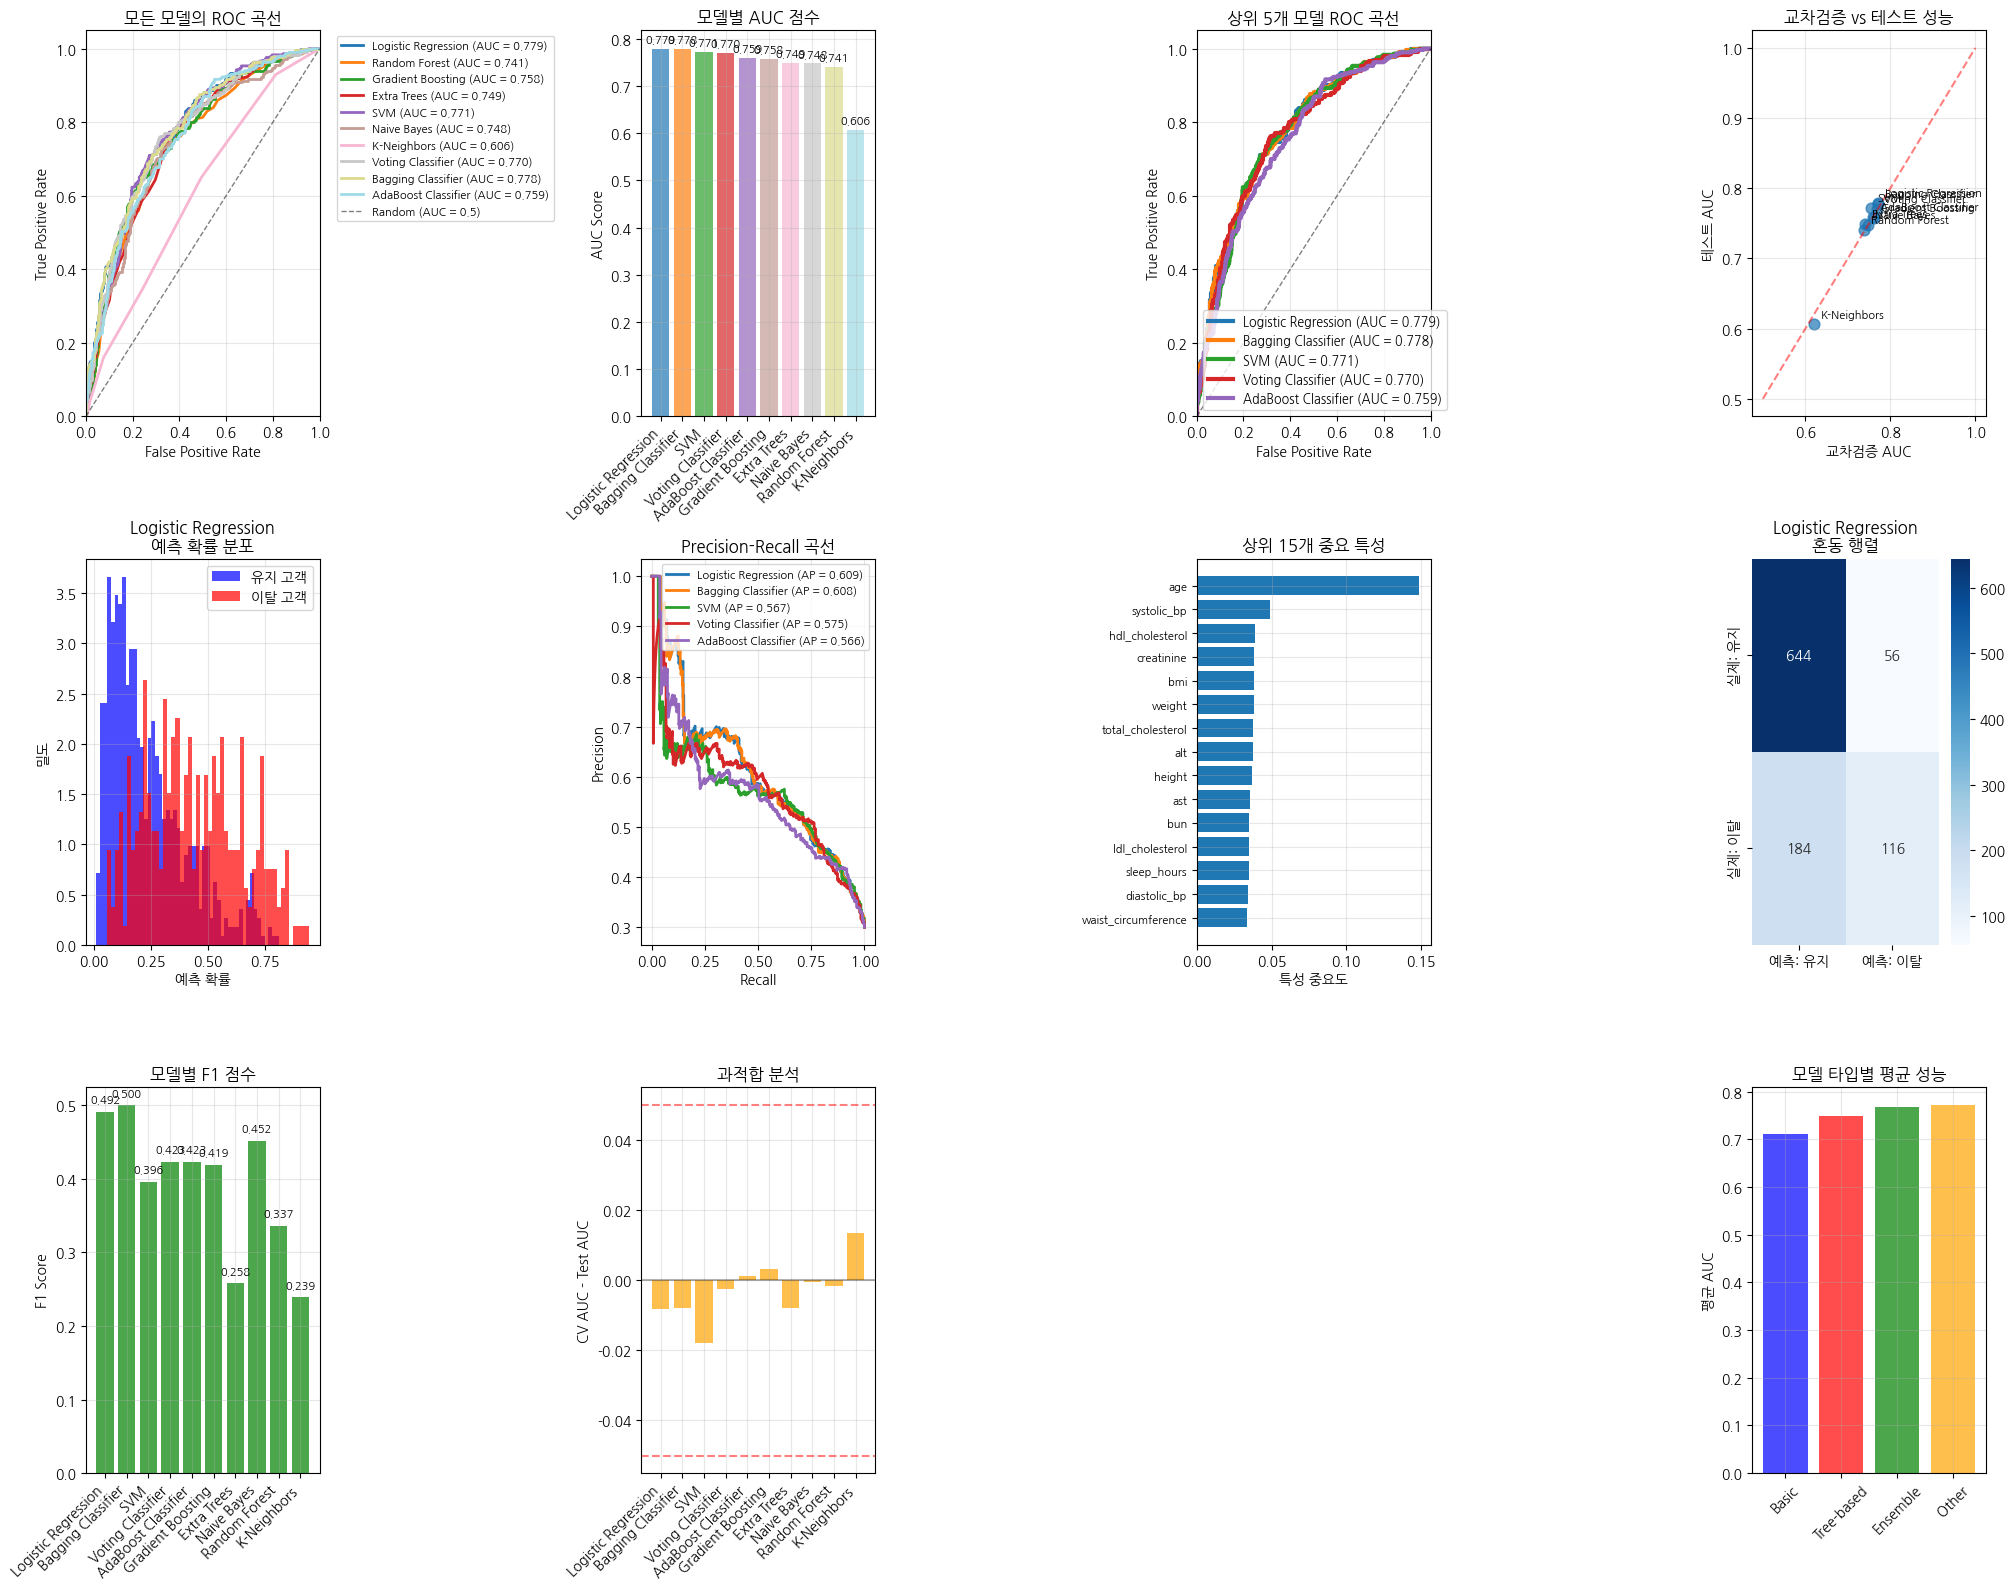


 8단계: 최종 분석 및 비즈니스 권장사항
------------------------------------------------------------
 최고 성능 모델: Logistic Regression
    테스트 AUC: 0.7788
    교차검증 AUC: 0.7704 (±0.0133)
    F1 점수: 0.4915

 비즈니스 인사이트:
 고위험 에 가장 영향을 미치는 요인들:
    1. age: 0.1489
    2. systolic_bp: 0.0489
    3. hdl_cholesterol: 0.0387
    4. creatinine: 0.0385
    5. bmi: 0.0383
    6. weight: 0.0380
    7. total_cholesterol: 0.0379
    8. alt: 0.0376
    9. height: 0.0370
   10. ast: 0.0359

 모델 선택 권장사항:
1. 성능 우선: Logistic Regression (AUC: 0.779)
2. 안정성 우선: AdaBoost Classifier
3. 해석 가능성: Logistic Regression 또는 Random Forest

 분석 완료! 총 10개 모델로 고위험 예측 성능을 비교했습니다.


In [5]:
# 3. 데이터 전처리
print(f"\n 데이터 전처리")
print("-" * 50)

# Define DEEP_LEARNING_AVAILABLE flag
DEEP_LEARNING_AVAILABLE = False # Set to True if you have deep learning libraries installed

# Import deep learning libraries if available
if DEEP_LEARNING_AVAILABLE:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping


# 특성과 타겟 분리
X = df.drop('high_risk', axis=1)
y = df['high_risk']

print(f" 사용할 특성 개수: {X.shape[1]}")

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. 모델 정의 및 학습
print(f"\n 5단계: 다양한 모델 정의 및 학습")
print("-" * 60)

# 기본 모델들
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=7)
}

# 앙상블 모델들
ensemble_models = {
    'Voting Classifier': VotingClassifier([
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ], voting='soft'),
    'Bagging Classifier': BaggingClassifier(
        estimator=LogisticRegression(random_state=42, max_iter=1000),
        n_estimators=50, random_state=42
    ),

    'AdaBoost Classifier': AdaBoostClassifier(random_state=42, n_estimators=50)
}

# 모든 모델 합치기
all_models = {**models, **ensemble_models}

# 딥러닝 모델 정의
if DEEP_LEARNING_AVAILABLE:
    def create_neural_network(input_dim):
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),

            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),

            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# 6. 모델 학습 및 성능 평가
print(" 모델 학습 및 성능 평가 중...")

results = {}
model_predictions = {}

# 기존 ML 모델들 학습
for name, model in all_models.items():
    print(f" {name} 학습 중...")

    # 교차 검증
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='roc_auc')

    # 모델 학습
    model.fit(X_train_scaled, y_train)

    # 예측
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_scaled)
        # decision_function 결과를 확률로 변환
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

    y_pred = (y_pred_proba > 0.5).astype(int)

    # ROC 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # 결과 저장
    results[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'f1': f1_score(y_test, y_pred)
    }
    model_predictions[name] = y_pred_proba

# 딥러닝 모델 학습
if DEEP_LEARNING_AVAILABLE:
    print(" Neural Network 학습 중...")

    # 모델 생성 및 학습
    nn_model = create_neural_network(X_train_scaled.shape[1])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = nn_model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # 예측
    nn_pred_proba = nn_model.predict(X_test_scaled, verbose=0).ravel()
    nn_pred = (nn_pred_proba > 0.5).astype(int)

    # ROC 계산
    fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_proba)
    roc_auc_nn = auc(fpr_nn, tpr_nn)

    results['Neural Network'] = {
        'fpr': fpr_nn,
        'tpr': tpr_nn,
        'auc': roc_auc_nn,
        'cv_mean': roc_auc_nn,  # 딥러닝은 별도 교차검증 안함
        'cv_std': 0,
        'f1': f1_score(y_test, nn_pred)
    }
    model_predictions['Neural Network'] = nn_pred_proba

print(" 모든 모델 학습 완료!")

# 7. 결과 시각화
print(f"\n 7단계: 결과 시각화 및 분석")
print("-" * 60)

# 성능 요약
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_AUC': [results[name]['auc'] for name in results.keys()],
    'CV_AUC_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_AUC_Std': [results[name]['cv_std'] for name in results.keys()],
    'F1_Score': [results[name]['f1'] for name in results.keys()]
})

performance_df['Overfitting'] = performance_df['CV_AUC_Mean'] - performance_df['Test_AUC']
performance_df = performance_df.sort_values('Test_AUC', ascending=False)

print(" 모델 성능 순위:")
print(performance_df.round(4))

# 시각화
plt.figure(figsize=(20, 16))

# 1. 모든 모델의 ROC 곡선
plt.subplot(3, 4, 1)
colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

for (name, data), color in zip(results.items(), colors):
    plt.plot(data['fpr'], data['tpr'], color=color, lw=2,
             label=f'{name} (AUC = {data["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('모든 모델의 ROC 곡선')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

# 2. AUC 점수 비교
plt.subplot(3, 4, 2)
model_names = performance_df['Model'].values
auc_scores = performance_df['Test_AUC'].values

bars = plt.bar(range(len(model_names)), auc_scores, color=colors[:len(model_names)], alpha=0.7)
plt.ylabel('AUC Score')
plt.title('모델별 AUC 점수')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# 3. 상위 5개 모델 ROC 곡선
plt.subplot(3, 4, 3)
top_5_models = performance_df.head(5)['Model'].values

for name in top_5_models:
    data = results[name]
    plt.plot(data['fpr'], data['tpr'], lw=3,
             label=f'{name} (AUC = {data["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('상위 5개 모델 ROC 곡선')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 4. 교차검증 vs 테스트 성능
plt.subplot(3, 4, 4)
cv_means = performance_df['CV_AUC_Mean'].values
test_scores = performance_df['Test_AUC'].values

plt.scatter(cv_means, test_scores, alpha=0.7, s=60)
plt.plot([0.5, 1], [0.5, 1], 'r--', alpha=0.5)
plt.xlabel('교차검증 AUC')
plt.ylabel('테스트 AUC')
plt.title('교차검증 vs 테스트 성능')

for i, name in enumerate(performance_df['Model'].values):
    plt.annotate(name, (cv_means[i], test_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.grid(True, alpha=0.3)

# 5. 최고 성능 모델 예측 확률 분포
best_model_name = performance_df.iloc[0]['Model']
best_predictions = model_predictions[best_model_name]

plt.subplot(3, 4, 5)
plt.hist(best_predictions[y_test == 0], bins=50, alpha=0.7,
         label='유지 고객', color='blue', density=True)
plt.hist(best_predictions[y_test == 1], bins=50, alpha=0.7,
         label='이탈 고객', color='red', density=True)
plt.xlabel('예측 확률')
plt.ylabel('밀도')
plt.title(f'{best_model_name}\n예측 확률 분포')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Precision-Recall 곡선 (상위 5개)
plt.subplot(3, 4, 6)
for name in top_5_models:
    precision, recall, _ = precision_recall_curve(y_test, model_predictions[name])
    avg_precision = average_precision_score(y_test, model_predictions[name])
    plt.plot(recall, precision, lw=2,
             label=f'{name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall 곡선')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 7. 특성 중요도 (Random Forest)
if 'Random Forest' in all_models:
    plt.subplot(3, 4, 7)
    rf_model = all_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-15:]

    # Assuming feature_columns is a list or array of feature names
    # If not, you might need to get feature names from X.columns
    feature_columns = X.columns # Added this line to get feature names from X

    plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
    plt.yticks(range(len(top_features_idx)),
               [feature_columns[i] for i in top_features_idx], fontsize=8)
    plt.xlabel('특성 중요도')
    plt.title('상위 15개 중요 특성')
    plt.grid(True, alpha=0.3)

# 8. 혼동 행렬 (최고 성능 모델)
plt.subplot(3, 4, 8)
y_pred_best = (best_predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['예측: 유지', '예측: 이탈'],
            yticklabels=['실제: 유지', '실제: 이탈'])
plt.title(f'{best_model_name}\n혼동 행렬')

# 9. F1 Score 비교
plt.subplot(3, 4, 9)
f1_scores = performance_df['F1_Score'].values
bars = plt.bar(range(len(model_names)), f1_scores, alpha=0.7, color='green')
plt.ylabel('F1 Score')
plt.title('모델별 F1 점수')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# 10. 과적합 분석
plt.subplot(3, 4, 10)
overfitting = performance_df['Overfitting'].values
colors_overfit = ['red' if x > 0.05 else 'green' if x < -0.05 else 'orange' for x in overfitting]

bars = plt.bar(range(len(model_names)), overfitting, color=colors_overfit, alpha=0.7)
plt.ylabel('CV AUC - Test AUC')
plt.title('과적합 분석')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 11. 딥러닝 학습 곡선 (if available)
if DEEP_LEARNING_AVAILABLE:
    plt.subplot(3, 4, 11)
    plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('신경망 학습 곡선')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 12. 모델 타입별 성능 비교
plt.subplot(3, 4, 12)
model_types = {
    'Basic': ['Logistic Regression', 'Naive Bayes', 'K-Neighbors'],
    'Tree-based': ['Random Forest', 'Gradient Boosting', 'Extra Trees'],
    'Ensemble': ['Voting Classifier', 'Bagging Classifier', 'AdaBoost Classifier'],
    'Other': ['SVM'] + (['Neural Network'] if DEEP_LEARNING_AVAILABLE else [])
}

type_performance = {}
for type_name, model_list in model_types.items():
    scores = [performance_df[performance_df['Model'] == model]['Test_AUC'].values[0]
             for model in model_list if model in performance_df['Model'].values]
    if scores:
        type_performance[type_name] = np.mean(scores)

if type_performance:
    types = list(type_performance.keys())
    scores = list(type_performance.values())
    plt.bar(types, scores, alpha=0.7, color=['blue', 'red', 'green', 'orange'][:len(types)])
    plt.ylabel('평균 AUC')
    plt.title('모델 타입별 평균 성능')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# 8. 최종 분석 및 권장사항
print(f"\n 8단계: 최종 분석 및 비즈니스 권장사항")
print("-" * 60)

best_model = performance_df.iloc[0]
print(f" 최고 성능 모델: {best_model['Model']}")
print(f"    테스트 AUC: {best_model['Test_AUC']:.4f}")
print(f"    교차검증 AUC: {best_model['CV_AUC_Mean']:.4f} (±{best_model['CV_AUC_Std']:.4f})")
print(f"    F1 점수: {best_model['F1_Score']:.4f}")

print(f"\n 비즈니스 인사이트:")
print("=" * 50)

# 특성 중요도 분석 (Random Forest 기준)
if 'Random Forest' in all_models:
    rf_model = all_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    important_features = sorted(zip(feature_columns, feature_importance),
                              key=lambda x: x[1], reverse=True)[:10]

    print(" 고위험 에 가장 영향을 미치는 요인들:")
    for i, (feature, importance) in enumerate(important_features, 1):
        print(f"   {i:2d}. {feature}: {importance:.4f}")

print(f"\n 모델 선택 권장사항:")
print(f"1. 성능 우선: {performance_df.iloc[0]['Model']} (AUC: {performance_df.iloc[0]['Test_AUC']:.3f})")
print(f"2. 안정성 우선: {performance_df.nsmallest(3, 'CV_AUC_Std').iloc[0]['Model']}")
print(f"3. 해석 가능성: Logistic Regression 또는 Random Forest")


print(f"\n 분석 완료! 총 {len(results)}개 모델로 고위험 예측 성능을 비교했습니다.")

**Overfitting = CV_AUC_Mean - Test_AUC**


" 교차검증 평균 AUC - 테스트셋 AUC "



의미:

이 값이 0에 가까울수록 모델의 실제 성능(Test AUC)이 교차검증 성능과 비슷해서 안정적이라는 뜻입니다.


이 값이 양수라면,

"교차검증에서는 성능이 잘 나왔는데, 실제 테스트셋에서는 더 낮다"

→ 과적합(Overfitting) 경향이 있다고 해석


이 값이 음수라면,

"테스트셋에서 성능이 더 잘 나왔다"는 뜻

→ 일반적으로 매우 드물지만, 운이 좋거나 데이터 분할 등 여러 요인으로
 생길 수 있음

